## Homogenous (stationary) Markov Chain Implementation in Edward

### Package Imports and Options

In [10]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import tensorflow as tf
import edward as ed
from edward.models import Bernoulli, Categorical, Normal, Empirical, Multinomial

In [11]:
from os.path import join, abspath
import sys
sys.path.append(join(abspath('.'), '../utils'))
from utils import load_dataframe, preprocessing

In [12]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', -1)
sns.set_style('whitegrid')

### Load Data

In [13]:
df_raw = load_dataframe()

Loading raw data from hdf5 cache...
Fetching raw data took 3.32 seconds
id             int64   
loan_status    category
age_of_loan    int64   
term           category
dtype: object
Retrieved 40,268,594 rows, 4 columns


In [14]:
df = df_raw.copy()

### Analysis

In [24]:
counts = df.groupby(['term', 'age_of_loan', 'loan_status']).count()

In [25]:
counts.head(20)

id
term age_of_loan loan_status                  
36   0           Charged Off        NaN       
                 Current             4352.0   
                 Default            NaN       
                 Fully Paid          11514.0  
                 In Grace Period    NaN       
                 Issued              18937.0  
                 Late (16-30 days)  NaN       
                 Late (31-120 days) NaN       
     1           Charged Off         13.0     
                 Current             1491931.0
                 Default            NaN       
                 Fully Paid          13073.0  
                 In Grace Period     87.0     
                 Issued              4.0      
                 Late (16-30 days)   2239.0   
                 Late (31-120 days)  1313.0   
     2           Charged Off         53.0     
                 Current             1448677.0
                 Default            NaN       
                 Fully Paid          13372.0

In [26]:
# get currently active loans
df_active = df.loc[df.age_of_loan < df.term.astype(int)].reset_index(drop=True)
df_inactive = df.loc[~(df.age_of_loan < df.term.astype(int))].reset_index(drop=True)
df_active.shape[0] + df_inactive.shape[0] == df.shape[0]

True

In [ ]:
df_active.shape

In [ ]:
df_inactive.shape

In [ ]:
df_active.dtypes

In [ ]:
sns.distplot(df.age_of_loan)

In [ ]:
sns.distplot(df_active.age_of_loan)

In [ ]:
sns.distplot(df_inactive.age_of_loan)

In [27]:
# split active loans by 36 and 60 month terms
df_active_36 = df_active.loc[df_active.term.astype(int) == 36]
df_active_60 = df_active.loc[df_active.term.astype(int) == 60]
df_active_36.shape[0] + df_active_60.shape[0] == df_active.shape[0]

True

In [ ]:
df_active_36.shape

In [ ]:
df_active_60.shape

In [ ]:
sns.distplot(df_active_36.age_of_loan)

In [ ]:
sns.distplot(df_active_60.age_of_loan)

In [ ]:
sns.countplot(x="loan_status", data=df_active_36)

In [ ]:
sns.countplot(x="loan_status", data=df_active_60)

In [ ]:
sns.distplot(df_active_36.loc[df_active_36.loan_status == 'Current'].age_of_loan)

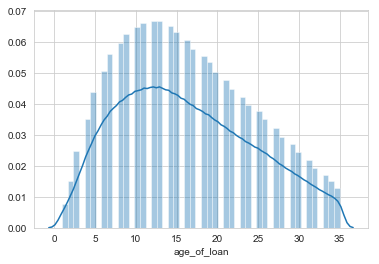

In [28]:
late = (df_active_36.loan_status == 'Late (16-30 days)') | (df_active_36.loan_status == 'Late (31-120 days)')
sns.distplot(df_active_36.loc[late].age_of_loan)

### Preprocessing

In [29]:
df = preprocess(df)

Loading preprocessed data from hdf5 cache...
Fetching preprocessed data took 4.99 seconds
Preprocessed 40,268,594 rows, 4 columns


In [ ]:
df.term.value_counts()

In [ ]:
df.loan_status.value_counts(sort=False)

**TODO** it might be good to use panda's Categorical type instead of sklearn's label encoder so we have the mapping between indew and category directly from the dataframe (or modify the preprocess function to return the label encoder objects too, but then it means we also need to cache them which is not super clean).

## Markov chain

In [19]:
statuses = df.loan_status.unique()
n_statuses = len(statuses)

In [20]:
n_statuses

8

In [16]:
df.loan_status.unique().categories

Index(['Current', 'Fully Paid', 'Late (16-30 days)', 'Late (31-120 days)',
       'Charged Off', 'Default', 'In Grace Period', 'Issued'],
      dtype='object')

In [18]:
df.loan_status.unique().shape[0]

8

### 0. Generating the transitions

This doesn't take too long (took me a while to figure out a clean way to do it):

In [24]:
df['previous_month'] = df.age_of_loan - 1
transitions =  pd.merge(df, df, left_on=['id', 'age_of_loan'], right_on=['id', 'previous_month'])

In [32]:
transitions.head()

,id,loan_status_x,age_of_loan_x,term_x,previous_month_x,loan_status_y,age_of_loan_y,term_y,previous_month_y
0,54734,1,1,0,0,1,2,0,1
1,54734,1,2,0,1,1,3,0,2
2,54734,1,3,0,2,1,4,0,3
3,54734,1,4,0,3,1,5,0,4
4,54734,1,5,0,4,1,6,0,5


### 1. Solving with MLE:

The MLE solution to a markov chain is simply the empirical counts, so easy to implement. This can give us a good baseline to check our bayesian results later:

**Step 1**: count the transitions

In [33]:
transition_counts = pd.crosstab(transitions['loan_status_x'],
                                transitions['loan_status_y'])

**Step 2**: transform the count dataframe to a count matrix:

In [34]:
transition_counts

loan_status_y,0,1,2,3,4,6,7
loan_status_x,,,,,,,
1,1245,35683001,4,898790,9517,260345,96747
2,45503,220,2952,135,0,5,770
3,0,0,0,12119,18,169,96
4,0,436,0,15,28,96,64
5,0,20644,0,852,2,64,1
6,7354,49743,0,3462,459,23156,198166
7,180234,38049,46679,3852,83,5512,546333


Note that row 0 is missing, we add it by hand and set it to 0. Same with column 5:

In [ ]:
for i in range(n_statuses):
    if i not in transition_counts.index:
        # if no row, create it and set to 0:
        print('Filling in row %s ...' % (i,))
        transition_counts.loc[i] = 0
    if i not in transition_counts.columns:
        # if no column, create it and set to 0:
        print('Filling in column %s ...' % (i,))
        transition_counts[i] = 0

In [ ]:
transition_counts

Re-sort the indexes:

In [ ]:
transition_counts.sort_index(axis=0, inplace=True)
transition_counts.sort_index(axis=1, inplace=True)

In [ ]:
transition_counts

Note with crosstab we could have gotten the frequencies directly, but having this raw count table might be useful for the Bayesian case.

We can also get the margins directly (sum by row), but then sort_index fails...

In [ ]:
transitions_mle = transition_counts.values.astype(float)

In [ ]:
for i in range(transitions_mle.shape[0]):
    n_i_all = sum(transitions_mle[i,:]) # count how many i => j for this i and any j
    if n_i_all != 0:
        transitions_mle[i,:] *= (1/n_i_all)

In [ ]:
np.round(transitions_mle, 2)

In [57]:
df.loan_status.unique()

array([1, 3, 6, 7, 0, 2, 4, 5])

In [58]:
df.loan_status.value_counts()

1    37859913
3    951255  
7    843537  
6    292358  
0    234296  
2    49490   
5    22905   
4    10233   
Name: loan_status, dtype: int64

In [59]:
transition_counts

loan_status_y,0,1,2,3,4,5,6,7
loan_status_x,,,,,,,,
0,0,0,0,0,0,0,0,0
1,1245,35679469,4,898628,9517,0,260336,96651
2,45449,220,2861,135,0,0,5,770
3,0,0,0,12119,18,0,169,96
4,0,436,0,15,28,0,96,64
5,0,20644,0,852,2,0,64,1
6,7354,49741,0,3462,459,0,23156,198158
7,180232,38013,46625,3840,83,0,5512,546017


In [69]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_raw.loan_status)

LabelEncoder()

In [72]:
mapping = {i: le.inverse_transform([i]) for i in range(8)}

In [71]:
transition_counts_2 = transition_counts.copy()

In [82]:
transition_counts_2.index = [l[0] for l in list(list(v) for v in mapping.values())]
transition_counts_2.columns = [l[0] for l in list(list(v) for v in mapping.values())]

In [83]:
transition_counts_2

,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
Charged Off,0,0,0,0,0,0,0,0
Current,1245,35679469,4,898628,9517,0,260336,96651
Default,45449,220,2861,135,0,0,5,770
Fully Paid,0,0,0,12119,18,0,169,96
In Grace Period,0,436,0,15,28,0,96,64
Issued,0,20644,0,852,2,0,64,1
Late (16-30 days),7354,49741,0,3462,459,0,23156,198158
Late (31-120 days),180232,38013,46625,3840,83,0,5512,546017


todo look at FP -> late

look at when igp happens, when is it taken into account

### 2. Bayesian Estimation, Multinomial Model

In [ ]:
import tensorflow as tf
import edward as ed

**Based on the paper "Markov Chain Models for Delinquency: Transition Matrix Estimation and Forecasting", Scott D. Grimshaw, William P. Alexander, Section 3**

We can model the counts of the transitions with a multinomial. More specifically:

We call $f(j)$ the row vector of monthly movements: $f(j,k)$ is the number of accounts that start the month in state $j$ and move to state $k$. We model this vector's distribution as a multinomial.

The multinomial follows probabilities, denoted as $p(j,k)$ in the paper, that are the probability of each individual transition j => k.

And the prior is the Dirichlet distribution with parameters $\alpha(j)$.

In [43]:
transition_counts.iloc[1,:].values

array([    1245, 35679469,        4,   898628,     9517,        0,
         260336,    96651])

**Transition counts, per month:**

In [44]:
transitions.head()

,id,loan_status_x,age_of_loan_x,term_x,previous_month_x,loan_status_y,age_of_loan_y,term_y,previous_month_y
0,54734,1,1,0,0,1,2,0,1
1,54734,1,2,0,1,1,3,0,2
2,54734,1,3,0,2,1,4,0,3
3,54734,1,4,0,3,1,5,0,4
4,54734,1,5,0,4,1,6,0,5


In [45]:
transition_counts_per_month = transitions.groupby(['previous_month_x', 'loan_status_x', 'loan_status_y']).size()

In [46]:
temp = list()
for month in transition_counts_per_month.index.levels[0]:
    temp.append(transition_counts_per_month[month].unstack().fillna(0))
transition_counts_per_month = temp

In [47]:
transition_counts_per_month[0]

loan_status_y,1,3,4,6,7
loan_status_x,,,,,
1,5162.0,219.0,1.0,8.0,21.0
3,0.0,48.0,0.0,1.0,0.0
5,20644.0,852.0,2.0,64.0,1.0


In [48]:
for counts in transition_counts_per_month:
    for i in range(n_statuses):
        if i not in counts.index:
            # if no row, create it and set to 0:
            # print('Filling in row %s ...' % (i,))
            counts.loc[i] = 0
        if i not in counts.columns:
            # if no column, create it and set to 0:
            # print('Filling in column %s ...' % (i,))
            counts[i] = 0
    counts.sort_index(axis=0, inplace=True)
    counts.sort_index(axis=1, inplace=True)

In [49]:
transition_counts_per_month[0]

loan_status_y,0,1,2,3,4,5,6,7
loan_status_x,,,,,,,,
0,0,0.0,0,0.0,0.0,0,0.0,0.0
1,0,5162.0,0,219.0,1.0,0,8.0,21.0
2,0,0.0,0,0.0,0.0,0,0.0,0.0
3,0,0.0,0,48.0,0.0,0,1.0,0.0
4,0,0.0,0,0.0,0.0,0,0.0,0.0
5,0,20644.0,0,852.0,2.0,0,64.0,1.0
6,0,0.0,0,0.0,0.0,0,0.0,0.0
7,0,0.0,0,0.0,0.0,0,0.0,0.0


In [50]:
n_accounts = df.id.nunique()

In [51]:
n_accounts

2131441

### 2.1 MODEL

In [52]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

data = np.array([month_counts.iloc[2,:].values for month_counts in transition_counts_per_month])

# MODEL
# trying to build a model just for the first row:
pi = ed.models.Dirichlet(tf.ones(n_statuses))

# TODO define counts for each row
# (since there aren't too many rows we can just do a loop instead of using a matrix)
# total_count is the number of individual draws for each sample of the multinomial
counts = ed.models.Multinomial(total_count=data.sum(axis=1).astype(np.float32), probs=pi)

### 2.2 INFERENCE

**Note:** In all the edward example they tend to create the variables with tf.get_variable rather than tf.Variable. This will create a new var if no var with the same name already exist, and otherwise re-use the older one. I don't like this that much when experimenting, because it can become a mess, you have to call reset_default_graph often... At least for the Inference part, I created the variables with tf.Var() instead, because we need to overwrite qpi (for example) multiple times:

#### 2.2.1 Variational Inference (KLqp)

The example I found used tf.nn.softplus, not sure why exactly, need to check...

The inference.run() method for KLqp takes as input n_samples = Number of samples from variational model for calculating stochastic gradients. I left it to 1 for now (default).

In [53]:
# qpi = ed.models.Dirichlet(tf.nn.softplus(tf.get_variable("qpi/concentration", [n_statuses])), name="qpi")
qpi = ed.models.Dirichlet(
    tf.nn.softplus(tf.Variable(name="qpi/concentration",
                               expected_shape=[n_statuses],
                               initial_value=tf.constant(1.0/n_statuses, shape=[n_statuses]))), name="qpi")

inference = ed.KLqp({pi: qpi}, data={counts: data})
inference.run(n_iter=500)

# CRITICISM
print("Inferred pi: {}".format(sess.run(qpi.mean())))

/Users/jeromekafrouni/.pyenv/versions/3.6.1/envs/prob-prog/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 5782.331
Inferred pi: [0.7548411  0.02239267 0.07160637 0.01922306 0.01932448 0.01507482
 0.02894686 0.06859059]


Once, I got it to randomly converge to this: [0.66669214 0.02093365 0.10725855 0.01944017 0.06792089 0.04235639 0.04178157 0.03361673]

Without tf.nn.softplus, same:

In [54]:
# qpi = ed.models.Dirichlet(tf.get_variable("qpi/concentration", [n_statuses]), name="qpi")
qpi = ed.models.Dirichlet(tf.Variable(name="qpi/concentration",
                               expected_shape=[n_statuses],
                               initial_value=tf.constant(1.0/n_statuses, shape=[n_statuses])), name="qpi")

inference = ed.KLqp({pi: qpi}, data={counts: data})
inference.run(n_iter=500)

# CRITICISM
print("Inferred pi: {}".format(sess.run(qpi.mean())))

500/500 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 26495.760
Inferred pi: [0.22504617 0.15220492 0.08478747 0.08997159 0.12081517 0.06958628
 0.13417296 0.12341552]


Sometimes it converges to nan loss and nan qpi, sometimes it converges to bad results... need to figure this out

#### 2.2.2 MCMC: HMC ("black box" Monte Carlo)

This fails, the error is related to https://github.com/blei-lab/edward/issues/785.
I think the error is linked to the fact that dirichlet is actually defined in a k-1 dimensional space (because vectors need to sum up to 1).

In Edward MCMC requires that latent vars have "unconstrained support" (see edward/inferences/hmc.py). They say that setting auto_transform=True should make the vars unconstrained and fix the problem...

About auto_transform: *Automated transformations provide convenient handling of constrained continuous variables during inference by transforming them to an unconstrained space. Automated transformations are crucial for expanding the scope of algorithm classes such as gradient-based Monte Carlo and variational inference with reparameterization gradients.*

But it doesn't seem to work...

In [ ]:
T = 5000 # number of posterior samples => the "M" in our lecture on MCMC (length of MC used for inference)

# the approximating family has to be an empirical distribution in MCMC:
# qpi = ed.models.Empirical(params=tf.get_variable("qpi/params", [T, n_statuses],
#       initializer=tf.constant_initializer(1.0 / n_statuses))) # initialize as uniform probs
qpi = ed.models.Empirical(tf.Variable(name="qpi/params", expected_shape=[T, n_statuses],
                                      initial_value=tf.constant(1.0/n_statuses, shape=[T, n_statuses])))

inference = ed.inferences.HMC(latent_vars={pi: qpi}, data={counts: data}) # passing auto_transform fails
inference.run(step_size=1e-3)

# CRITICISM
print("Inferred pi: {}".format(sess.run(qpi.mean()))) 

**MCMC: Gibbs**

We define qpi similarly as for HMC (Empirical)

In [55]:
T = 5000 # number of posterior samples => the "M" in our lecture on MCMC (length of MC used for inference)

# the approximating family has to be an empirical distribution in MCMC:
# qpi = ed.models.Empirical(params=tf.get_variable("qpi/params", [T, n_statuses],
#       initializer=tf.constant_initializer(1.0 / n_statuses))) # initialize as uniform probs
qpi = ed.models.Empirical(tf.Variable(name="qpi/params", expected_shape=[T, n_statuses],
                                      initial_value=tf.constant(1.0/n_statuses, shape=[T, n_statuses])))

# self.qu = ed.models.Empirical(params=tf.Variable(tf.zeros([n_iter, self.N, self.K]), name="qu"))
inference = ed.inferences.Gibbs(latent_vars={pi: qpi}, data={counts: data})
inference.run()

# CRITICISM
print("Inferred pi: {}".format(sess.run(qpi.mean()))) 

5000/5000 [100%] ██████████████████████████████ Elapsed: 8s | Acceptance Rate: 1.000
Inferred pi: [9.19138551e-01 4.47059423e-03 5.78967817e-02 2.74759904e-03
 1.99671213e-05 1.99579590e-05 1.21376645e-04 1.55859394e-02]


These results seem pretty good so that's promising!

Next steps:
- Figure out with HMC fails
- Figure out why KLqp fails (but maybe we can leave that for later)
- Run Gibbs but for the full model i.e. one multinomial per row, with a list of variables
- Run Gibbs for the full model but with a matrix

- Develop our model more
- Stop using the multinomial model and formalize directly as a Markov Model, as in https://github.com/blei-lab/edward/issues/450.
- Think about criticism

### 3. Bayesian Estimation, Markov Chain